# Vergleich unterschiedlicher CNN Modelle

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.2.1')

1.2.1


In [7]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.6')

Using TensorFlow backend.


2.0.8


In [8]:
# We need keras 2.0.6 or later as this is the version we created the model with
# !pip install keras --upgrade

## Laden realistischer Daten

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/real-world.zip
from zipfile import ZipFile
zip = ZipFile(r'real-world.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1203k  100 1203k    0     0  2218k      0 --:--:-- --:--:-- --:--:-- 2217k


In [10]:
!ls -l real-world

total 0
drwxr-xr-x 2 nbuser nbuser 0 Aug 29 10:01 0
drwxr-xr-x 2 nbuser nbuser 0 Aug 29 10:01 1
drwxr-xr-x 2 nbuser nbuser 0 Aug 29 10:01 2
drwxr-xr-x 2 nbuser nbuser 0 Aug 29 10:01 3
drwxr-xr-x 2 nbuser nbuser 0 Aug 29 10:01 4
drwxr-xr-x 2 nbuser nbuser 0 Aug 29 10:01 5


In [11]:
import os
import skimage.data
import skimage.transform

def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    all_file_names = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
            all_file_names.append(f)
    # Resize images
    images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]
    return images64, labels, all_file_names

In [12]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "real-world")

images, labels, file_names = load_data(data_dir)

In [13]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    plt.figure(figsize=(15, 15))
    i = 0
    for label in labels:
        # Pick the first image for each label.
        image = images[i]
        plt.subplot(4, 4, i + 1)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("{0}".format(label))
        i += 1
        plt.imshow(image)
    plt.show()

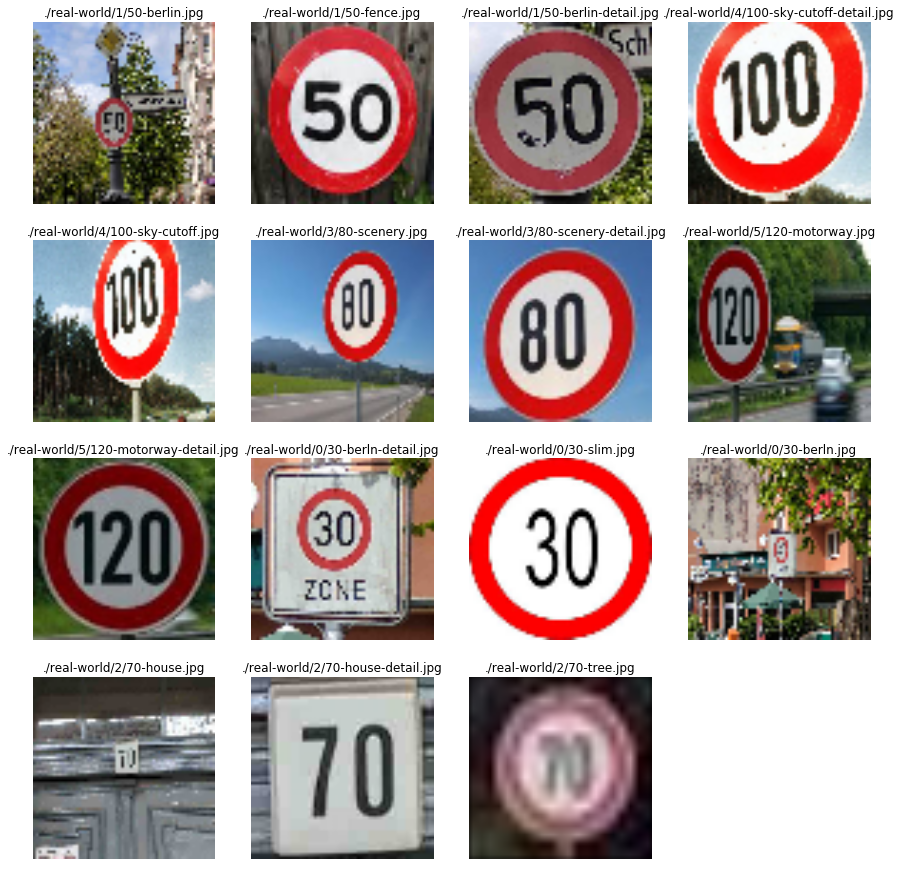

In [14]:
display_images_and_labels(images, file_names)

## Vergleich der Modelle

In [15]:
from keras.models import load_model

In [16]:
BATCH_SIZE = 500

y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [17]:
import skimage.transform
def predict_single(image):
    # normalize
    X_sample = np.array([image])
    prediction = model.predict(X_sample)
    predicted_category = np.argmax(prediction, axis=1)
    return predicted_category, prediction

In [18]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(6, 3,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

---

### Unser erstes VGG artiges Modell mit kleinem Trainingsdatensatz
#### In wenigen Minuten auf K80 Traininert

In [19]:
!curl -O https://transfer.sh/B1W8e/conv-vgg.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54.8M  100 54.8M    0     0  2468k      0  0:00:22  0:00:22 --:--:--  509k


In [20]:
model = load_model('conv-vgg.hdf5')

In [21]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

15/15 [==============================] - 0s


(5.5411748886108398, 0.60000002384185791)

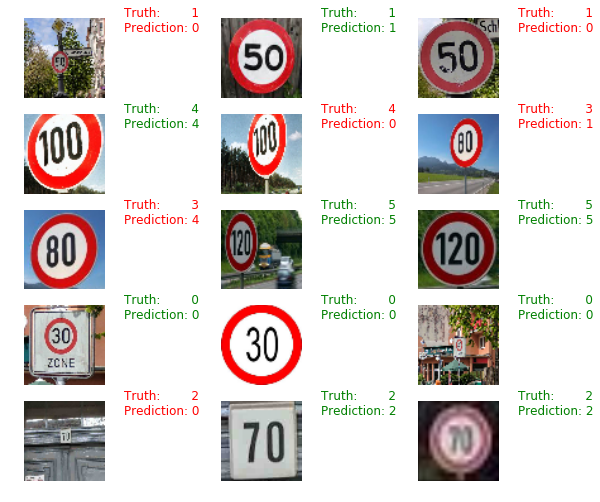

In [ ]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

In [28]:
### Bewertung
#### 9 von 15 richtig und 60% Accuracy
#### Erstaunlich gute Werte

---

### Dasselbe Modell mit augmented Trainingsdatensatz

![Accuracy Curve](https://djcordhose.github.io/ai/img/tensorboard/augmented-acc.png)
![Validation Accuracy Curve](https://djcordhose.github.io/ai/img/tensorboard/augmented-val-acc.png)

In [ ]:
!curl -O https://transfer.sh/Cvcar/conv-vgg-augmented.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54.8M  100 54.8M    0     0   392k      0  0:02:23  0:02:23 --:--:--  749k:12  0:02:36  334k


In [25]:
model = load_model('conv-vgg-augmented.hdf5')

In [26]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

15/15 [==============================] - 0s


(5.9101090431213379, 0.3333333432674408)

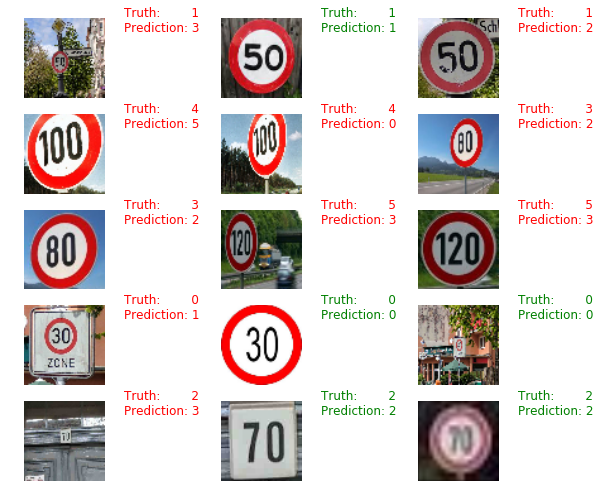

In [27]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

#### Nur 5 von 15 richtig und 33% Accuracy
#### 4,5 Std Trainingszeit auf K80, scheint dennoch nicht komplett austrainiert
#### Ein enttäuschendes Ergebnis, das komplett austrainiert wahrscheinlich noch schlechter wäre
#### Generalisierung auf Bilder aus dem echten Leben hat nicht funktioniet